<a href="https://colab.research.google.com/github/sardor-egamov/backend_test_homework/blob/master/%D0%95%D1%89%D1%91_%D0%BE%D0%B4%D0%BD%D0%B0_%D0%BA%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0_%22how_to_use_graphcast_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lewingtonpitsos Remote Graphcast

We will make predictions with remote-graphcast and compare them to [ERA5](https://www.ecmwf.int/en/forecasts/dataset/ecmwf-reanalysis-v5#:~:text=ERA5%20is%20the%20fifth%20generation,land%20and%20oceanic%20climate%20variables) Reanalysis and predictions downloaded from [Open-Meteo](https://open-meteo.com/)

- Install/Import dependencies
- Set credentials/parameters
- Create graphcast forcasts through runpod
- Download Open-Meteo Reanalysis and historical forcasts for points of interest
- Download ERA5 Reanalysis
- Create a dataframe of forcasts/reanalysis for each point of interest
- Plot forcasts/reanalysis and compare for one point in space
- Plot forcasts/reanalysis and compare for all points

## Links

- Walkthrough video: https://youtu.be/BTyhgp9Hugc
- Github: https://github.com/Lewington-pitsos/remote-graphcast
- Pypi: https://pypi.org/project/remote-graphcast/
- CDS: api key https://cds.climate.copernicus.eu/api-how-to
- Why you have to start forcasts at 6:00: https://youtu.be/PD1v5PCJs_o?t=1919
- Docker Image: https://hub.docker.com/r/lewingtonpitsos/easy-graphcast
- Runpod link (affiliate, same price, just 2% goes to me instead of runpod): https://runpod.io?ref=wyncd0v9
- Runpod link (non affiliate): https://www.runpod.io/

If you use the affiliate link that would be amazing, I would feel very appriciated for all the work I did and it costs the same.

In [ ]:
! pip install remote_graphcast openmeteo-requests requests_cache boto3 pandas retry_requests climetlab netCDF4

In [ ]:
# @title Credentials
# https://cds.climate.copernicus.eu/api-how-to
aws_access_key_id = '' # @param {type:"string"}
aws_secret_access_key = '' # @param {type:"string"}
aws_bucket = '' # @param {type:"string"}
cds_url = 'https://cds.climate.copernicus.eu/api/v2' # @param {type:"string"} # https://cds.climate.copernicus.eu/api-how-to
cds_key = '' # @param {type:"string"}
runpod_key = '' # @param {type:"string"}

In [ ]:
from remote_graphcast import remote_cast
import openmeteo_requests
import requests_cache
import pandas as pd
from retry_requests import retry
import os
import boto3
import climetlab as cml
import datetime
import xarray
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

INFO: 2024-01-18 00:17:35 NumExpr defaulting to 2 threads.


# Generate Graphcast Forcasts with [remote_graphcast](https://pypi.org/project/remote-graphcast/)

In [ ]:
# this will take around 10 minutes in the best case, possibly up to 1 hour if CDS copernicus is being slow

forcast_list ="[{'start': '2023122306', 'hours_to_forcast': 241}]"

upload_location = remote_cast(
	aws_access_key_id=aws_access_key_id,
	aws_secret_access_key=aws_secret_access_key,
	aws_bucket=aws_bucket,
	cds_url=cds_url,
	cds_key=cds_key,
	forcast_list=forcast_list,
	# dates to forcast from, note the weird quasi-JSON format, of this string, use single quotes instead of double quotes
	# select a date in the future and it will raise an error without spinning up anything
	runpod_key=runpod_key,
	gpu_type_id="NVIDIA A100-SXM4-80GB", # graphcast needs at least 61GB GPU ram (unless you want to quantize)
	container_disk_in_gb=50, # you'll need around 40GB per 10 day forcast + a healthy 10GB buffer
)

INFO: 2024-01-18 00:18:18 cast_id generated 2024-01-18_00-18-18_sylvan_jungle
INFO: 2024-01-18 00:18:18 validating input
INFO: 2024-01-18 00:18:19 input passed validation
INFO: 2024-01-18 00:18:20 forcasting pod created, id: m52xi5vyu5uxyc, machineId: axis6urhyaip, machine: {'podHostId': 'm52xi5vyu5uxyc-64411106'}
INFO: 2024-01-18 00:18:22 checking runpod and s3 for forcast status: all systems green
INFO: 2024-01-18 00:19:24 checking runpod and s3 for forcast status: all systems green
INFO: 2024-01-18 00:20:25 checking runpod and s3 for forcast status: all systems green
INFO: 2024-01-18 00:21:26 checking runpod and s3 for forcast status: all systems green
INFO: 2024-01-18 00:22:28 checking runpod and s3 for forcast status: all systems green
INFO: 2024-01-18 00:23:29 checking runpod and s3 for forcast status: all systems green
INFO: 2024-01-18 00:24:30 checking runpod and s3 for forcast status: all systems green
INFO: 2024-01-18 00:25:32 checking runpod and s3 for forcast status: all sy

In [ ]:
prefix = upload_location.replace("s3://" + aws_bucket + '/', "")

s3_client = boto3.client('s3', aws_access_key_id=aws_access_key_id, aws_secret_access_key=aws_secret_access_key)
for file in s3_client.list_objects(Bucket=aws_bucket, Prefix=prefix)['Contents']:
    graphcast_filename = file['Key'].split('/')[-1]
    print('saving to', graphcast_filename)
    s3_client.download_file(aws_bucket, file['Key'], graphcast_filename)

saving to .easy_graphcast_complete
saving to 2023122306-output


# Download [Open-Meteo](https://open-meteo.com/) Forcasts and Reanalysis

In [ ]:
def get_forcast(openmeteo, params):
	url = "https://api.open-meteo.com/v1/forecast"

	responses = openmeteo.weather_api(url, params=params)

	all_response_dfs = []
	for response in responses:

		# Process hourly data. The order of variables needs to be the same as requested.
		hourly = response.Hourly()
		hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()

		hourly_data = {"date": pd.date_range(
			start = pd.to_datetime(hourly.Time(), unit = "s"),
			end = pd.to_datetime(hourly.TimeEnd(), unit = "s"),
			freq = pd.Timedelta(seconds = hourly.Interval()),
			inclusive = "left"
		)}
		hourly_data["temperature_2m"] = hourly_temperature_2m
		hourly_data["latitude"] = response.Latitude()
		hourly_data["longitude"] = response.Longitude()
		idx = response.LocationId()
		hourly_data["requested_lat"] = params['latitude'][idx]
		hourly_data["requested_lon"] = params['longitude'][idx]


		hourly_dataframe = pd.DataFrame(data = hourly_data)
		# print(hourly_dataframe)
		all_response_dfs.append(hourly_dataframe)

	return pd.concat(all_response_dfs)

def get_reanalysis(openmeteo, params):
	url = "https://archive-api.open-meteo.com/v1/archive"
	responses = openmeteo.weather_api(url, params=params)

	# Process first location. Add a for-loop for multiple locations or weather models
	all_response_dfs = []
	for response in responses:

		# Process hourly data. The order of variables needs to be the same as requested.
		hourly = response.Hourly()
		hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()

		hourly_data = {"date": pd.date_range(
			start = pd.to_datetime(hourly.Time(), unit = "s"),
			end = pd.to_datetime(hourly.TimeEnd(), unit = "s"),
			freq = pd.Timedelta(seconds = hourly.Interval()),
			inclusive = "left"
		)}
		hourly_data["temperature_2m"] = hourly_temperature_2m
		hourly_data["latitude"] = response.Latitude()
		hourly_data["longitude"] = response.Longitude()
		idx = response.LocationId()
		hourly_data["requested_lat"] = params['latitude'][idx]
		hourly_data["requested_lon"] = params['longitude'][idx]


		hourly_dataframe = pd.DataFrame(data = hourly_data)
		all_response_dfs.append(hourly_dataframe)

	return pd.concat(all_response_dfs)

def get_om_data(params):
	# Setup the Open-Meteo API client with cache and retry on error
	cache_session = requests_cache.CachedSession('cruft/.cache', expire_after = 3600)
	retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
	openmeteo = openmeteo_requests.Client(session = retry_session)

	fo =  get_forcast(openmeteo, params)
	print('downloaded forcast')
	re = get_reanalysis(openmeteo, params)
	print('downloaded reanalysis')
	df = pd.merge(re, fo, on=['date', 'requested_lon', 'requested_lat'], how='outer', suffixes=['_reanalysis', '_forcast'])

	return df

In [ ]:
start_date = '2023-12-22'
end_date = '2024-02-07'
save_name = f'{start_date}-{end_date}-melbgrid'

params = {
	"latitude": [-38.5 , -38.5 , -38.5 , -38.5 , -38.5 , -38.5 , -38.5 , -38.25,
       -38.25, -38.25, -38.25, -38.25, -38.25, -38.25, -38.  , -38.  ,
       -38.  , -38.  , -38.  , -38.  , -38.  , -37.75, -37.75, -37.75,
       -37.75, -37.75, -37.75, -37.75, -37.5 , -37.5 , -37.5 , -37.5 ,
       -37.5 , -37.5 , -37.5 , -37.25, -37.25, -37.25, -37.25, -37.25,
       -37.25, -37.25, -37.  , -37.  , -37.  , -37.  , -37.  , -37.  ,
       -37.  ],
	"longitude": [144.25, 144.5 , 144.75, 145.  , 145.25, 145.5 , 145.75, 144.25,
       144.5 , 144.75, 145.  , 145.25, 145.5 , 145.75, 144.25, 144.5 ,
       144.75, 145.  , 145.25, 145.5 , 145.75, 144.25, 144.5 , 144.75,
       145.  , 145.25, 145.5 , 145.75, 144.25, 144.5 , 144.75, 145.  ,
       145.25, 145.5 , 145.75, 144.25, 144.5 , 144.75, 145.  , 145.25,
       145.5 , 145.75, 144.25, 144.5 , 144.75, 145.  , 145.25, 145.5 ,
       145.75],

	# "latitude": [-37.75],
	# "longitude": [145.0],
	"hourly": "temperature_2m",
	"start_date": "2023-12-22",
	"end_date": "2024-01-01",
}

df = get_om_data(params)

final_filename = f'om-{save_name}.csv'
print('saving to', final_filename)
df.to_csv(final_filename)

downloaded forcast
downloaded reanalysis
saving to om-2023-12-22-2024-02-07-melbgrid.csv


# Download [ERA5](https://www.ecmwf.int/en/forecasts/dataset/ecmwf-reanalysis-v5#:~:text=ERA5%20is%20the%20fifth%20generation,land%20and%20oceanic%20climate%20variables) data from the European Center for Medium range Weather Forcasts (ECMWF)



In [ ]:
CF_NAME_SFC = {
    "10u": "10m_u_component_of_wind",
    "10v": "10m_v_component_of_wind",
    "2t": "2m_temperature",
    "lsm": "land_sea_mask",
    "msl": "mean_sea_level_pressure",
    "tp": "total_precipitation_6hr",
    "z": "geopotential_at_surface",
}

class StateList():
	def __init__(self, start_date, forcast_length_hours, step_size, vars=CF_NAME_SFC.values()) -> None:
		self.start_date = start_date
		self.forcast_length_hours = forcast_length_hours
		self.step_size = step_size
		self.vars = vars

	def default_upper_bound(self):
		return self.start_date + datetime.timedelta(hours=self.forcast_length_hours)

	def dates(self, lower_bound=None, upper_bound='max'):
		wanted_dates = []
		if upper_bound == 'now':
			upper_bound = datetime.datetime.now()

		if upper_bound == 'max':
			upper_bound = self.default_upper_bound()

		for i in range(0, self.forcast_length_hours, self.step_size):
			candidate_date = self.start_date + datetime.timedelta(hours=i)
			is_wanted = True
			if lower_bound is not None:
				is_wanted = candidate_date > lower_bound
			if is_wanted and candidate_date < upper_bound:
				wanted_dates.append((i, candidate_date))
		return wanted_dates

	def dates_mapped_to_hours(self, **kwargs):
		dates = self.dates(**kwargs)
		date_hours = self._map_dates_to_hours([d for _, d in dates])
		days = self._split_dates_into_days(date_hours)
		return days

	def dates_as_strings(self, **kwargs):
		dates = self.dates(**kwargs)
		# convert to strings
		return [d.strftime("%Y%m%d%H") for _, d in dates]

	def _map_dates_to_hours(self, dates):
		date_hours = {}
		for d in dates:
			# datetime components to string, e.g. 20231117 ensureing that leading and trailing zeros are stil there
			day = str(d.year).zfill(4) + str(d.month).zfill(2) + str(d.day).zfill(2)
			if day not in date_hours:
				date_hours[day] = []
			date_hours[day].append(d.hour)

		return date_hours

	def _split_dates_into_days(self, date_hours):
		days = {}
		for day, hours in date_hours.items():
			k = str(".".join([str(h) for h in hours]))
			if k not in days:
				days[k] = []
			days[k].append((day, hours))

		segments = []

		for k, v in days.items():
			segment_data = []
			for day, hours in v:
				segment_data.append(day)

			segments.append((segment_data, v[0][1]))

		return segments


In [ ]:
p = StateList(datetime.datetime(2023, 12, 22, 12), 241, 6)
predicted_dates = p.dates_mapped_to_hours(
	upper_bound=datetime.datetime(2024, 1, 7, 23)
)

print('dates to download', predicted_dates)


all_ds = []
for date, hours in predicted_dates:
	ds = cml.load_source(
		"cds",
		"reanalysis-era5-single-levels",
		param=["2t"],
		product_type="reanalysis",
		grid='0.25/0.25',
		date=date,
		time=hours,
		area=[-36.5, 144.0, -39.0, 146.0], # lat max, lon min, lat min, lon max
	)
	all_ds.append(ds)

filename = '20231222-era5.nc'

ds = xarray.concat([d.to_xarray() for d in all_ds], dim='time')
ds.to_netcdf(filename)

dates to download [(['20231222'], [12, 18]), (['20231223', '20231224', '20231225', '20231226', '20231227', '20231228', '20231229', '20231230', '20231231'], [0, 6, 12, 18]), (['20240101'], [0, 6, 12])]


/usr/local/lib/python3.10/dist-packages/gribapi/__init__.py:23: UserWarning: ecCodes 2.31.0 or higher is recommended. You are running version 2.30.0
  warnings.warn(


# Compare the forcasts to the reanalysis

In [ ]:
def load_graphcast(graphcast_filename):
  graphcast_nc = graphcast_filename + '.nc'
  if not os.path.exists(graphcast_nc):
    ds = cml.load_source("file", graphcast_filename)
    ds = ds.sel(variable='2t')
    ds = ds.to_xarray()
    ds.to_netcdf(graphcast_nc)
    del ds

  return xr.open_dataset(graphcast_nc)

def load_comparison_data(df_filename, era_filename, graphcast_filename):
    df = pd.read_csv(df_filename)
    df = df[df['date'].str.contains('00:00:00|06:00:00|12:00:00|18:00:00')]
    df = df[df['date'] < '2024-01-01 12:00:00']
    df = df[df['date'] > '2023-12-22 06:00:00']

    era5_dataset = xr.open_dataset(era_filename)

    gc = load_graphcast(graphcast_filename)

    all_dfs = []
    # get all unique latitude-longitude combinations from df
    df['lat-lon'] = df['requested_lat'].astype(str) + '-' + df['requested_lon'].astype(str)

    for _, latlon in enumerate(df['lat-lon'].unique()):
        df_point = df[df['lat-lon'] == latlon]
        df_point = df_point.set_index('date', drop=False)

        latitude = df_point['requested_lat'].values[0]
        longitude = df_point['requested_lon'].values[0]

        era_point_data = era5_dataset.sel(latitude=latitude, longitude=latitude, method='nearest')
        t2m = era_point_data.t2m.values.flatten()[:-1]
        df_point['era5_2m'] = t2m - 273.15 # convert kelvin to celsius

        gc_point = gc.sel(latitude=latitude, longitude=longitude, method='nearest')
        df_point['gc_2m'] = gc_point['t2m'].values.flatten() - 273.15 # convert kelvin to celsius
        all_dfs.append(df_point)

    return all_dfs

In [ ]:
df_filename = 'om-2023-12-22-2024-02-07-melbgrid.csv'
era_filename = '20231222-era5.nc'
all_dataframes = load_comparison_data(df_filename, era_filename, graphcast_filename)
print(len(all_dataframes))

49


In [ ]:
df = all_dataframes[7]

In [ ]:
df

,Unnamed: 0,date,temperature_2m_reanalysis,latitude_reanalysis,longitude_reanalysis,requested_lat,requested_lon,temperature_2m_forcast,latitude_forcast,longitude_forcast,lat-lon,era5_2m,gc_2m
date,,,,,,,,,,,,,
2023-12-22 12:00:00,1860,2023-12-22 12:00:00,14.893000,-38.277679,144.24324,-38.25,144.25,14.248,-38.25,144.25,-38.25-144.25,13.982330,14.647308
2023-12-22 18:00:00,1866,2023-12-22 18:00:00,13.193000,-38.277679,144.24324,-38.25,144.25,12.648,-38.25,144.25,-38.25-144.25,12.048492,13.551849
2023-12-23 00:00:00,1872,2023-12-23 00:00:00,18.543000,-38.277679,144.24324,-38.25,144.25,19.298,-38.25,144.25,-38.25-144.25,18.466949,19.828949
2023-12-23 06:00:00,1878,2023-12-23 06:00:00,18.192999,-38.277679,144.24324,-38.25,144.25,18.848,-38.25,144.25,-38.25-144.25,19.672028,18.106842
2023-12-23 12:00:00,1884,2023-12-23 12:00:00,14.292999,-38.277679,144.24324,-38.25,144.25,13.798,-38.25,144.25,-38.25-144.25,13.180817,16.405243
2023-12-23 18:00:00,1890,2023-12-23 18:00:00,14.592999,-38.277679,144.24324,-38.25,144.25,13.748,-38.25,144.25,-38.25-144.25,12.717926,16.291046
2023-12-24 00:00:00,1896,2023-12-24 00:00:00,18.192999,-38.277679,144.24324,-38.25,144.25,19.448,-38.25,144.25,-38.25-144.25,18.299469,17.676971
2023-12-24 06:00:00,1902,2023-12-24 06:00:00,18.192999,-38.277679,144.24324,-38.25,144.25,15.898,-38.25,144.25,-38.25-144.25,15.233551,19.144196
2023-12-24 12:00:00,1908,2023-12-24 12:00:00,15.592999,-38.277679,144.24324,-38.25,144.25,15.448,-38.25,144.25,-38.25-144.25,14.091095,17.574310


INFO: 2024-01-18 00:37:05 Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO: 2024-01-18 00:37:05 Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO: 2024-01-18 00:37:05 Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO: 2024-01-18 00:37:05 Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO: 2024-01-18 00:37:05 Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings s

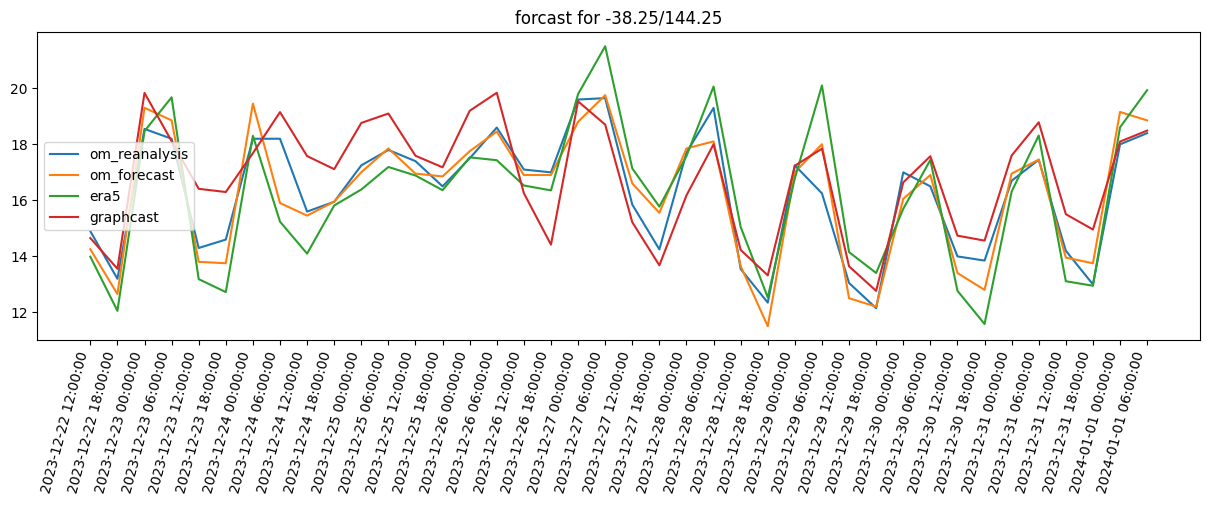

In [ ]:
plt.figure(figsize=(15,4))

plt.title(f"forcast for {df['requested_lat'][0]}/{df['requested_lon'][0]}")
plt.plot(df['date'], df['temperature_2m_reanalysis'])
plt.plot(df['date'], df['temperature_2m_forcast'])
plt.plot(df['date'], df['era5_2m'])
plt.plot(df['date'], df['gc_2m'])
plt.xticks(rotation=75, ha='right')
plt.legend(['om_reanalysis', 'om_forecast', 'era5', 'graphcast'])
print()

INFO: 2024-01-18 00:38:09 Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO: 2024-01-18 00:38:09 Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO: 2024-01-18 00:38:09 Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO: 2024-01-18 00:38:09 Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO: 2024-01-18 00:38:09 Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings s

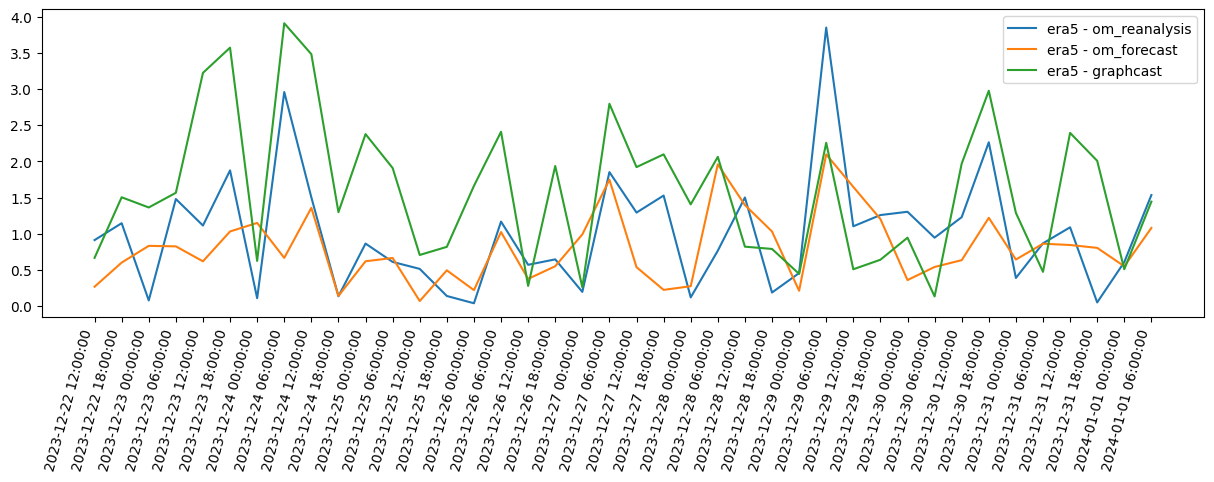

In [ ]:
plt.figure(figsize=(15,4))
plt.plot(df['date'], abs(df['era5_2m'] - df['temperature_2m_reanalysis']))
plt.plot(df['date'], abs(df['era5_2m'] - df['temperature_2m_forcast']))
plt.plot(df['date'], abs(df['era5_2m'] - df['gc_2m']))

plt.xticks(rotation=75, ha='right')
plt.legend(['era5 - om_reanalysis', 'era5 - om_forecast', 'era5 - graphcast'])

Text(0.5, 1.0, 'Mean Delta vs era5')

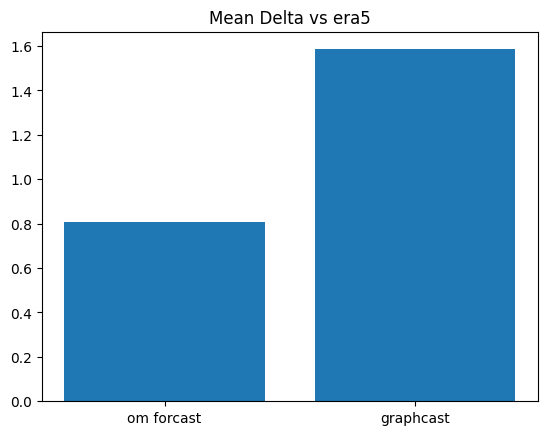

In [ ]:
plt.bar(['om forcast', 'graphcast'], [
    abs(df['era5_2m'] - df['temperature_2m_forcast']).mean(),
    abs(df['era5_2m'] - df['gc_2m']).mean()
])
plt.title('Mean Delta vs era5')


Text(0.5, 1.0, 'Om Forcast Error Over Lat/Long')

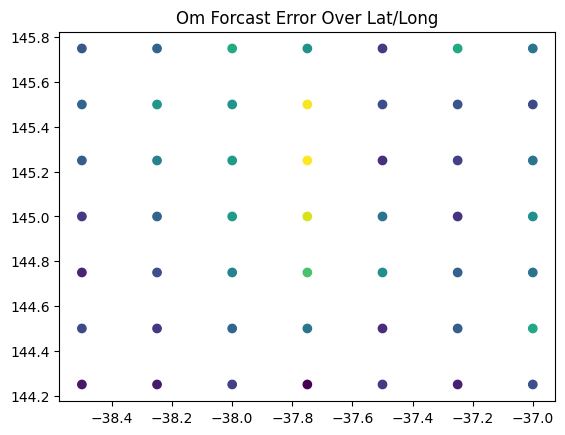

In [ ]:
data = []

for df in all_dataframes:
    latitude = df['requested_lat'].iloc[0]
    longitude = df['requested_lon'].iloc[0]

    forcast_err = abs(df['era5_2m'] - df['temperature_2m_forcast']).mean()
    graphcast_err = abs(df['era5_2m'] - df['gc_2m']).mean()

    data.append((latitude, longitude, forcast_err, graphcast_err))

# plot data as an image
data = np.array(data)
plt.scatter(data[:, 0], data[:, 1], c=data[:, 2])
plt.title("Om Forcast Error Over Lat/Long")

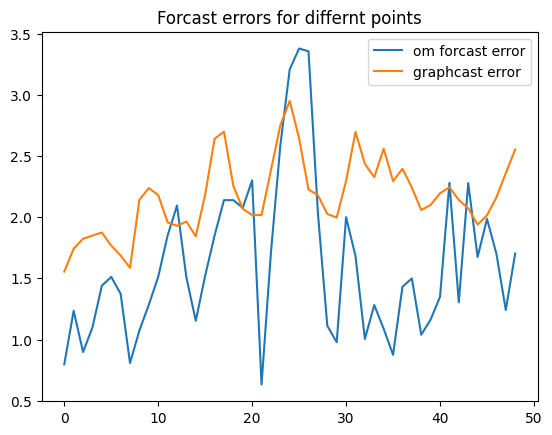

In [ ]:
plt.title('Forcast errors for differnt points')
plt.plot(data[:, 2])
plt.plot(data[:, 3])
plt.legend(['om forcast error', 'graphcast error'])


<BarContainer object of 2 artists>

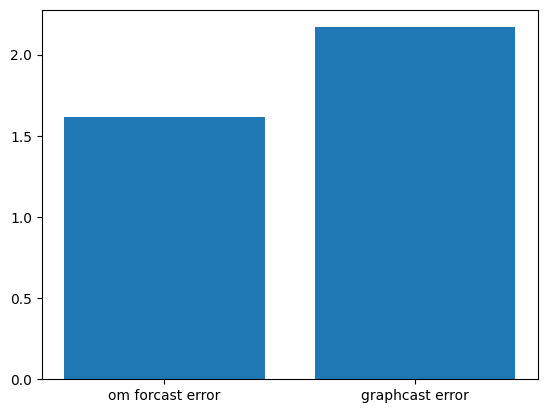

In [ ]:
plt.bar(['om forcast error', 'graphcast error'], [data[:, 2].mean(), data[:, 3].mean()])

In [ ]:
dfs = pd.concat(all_dataframes)
dfs['date'] = dfs.index
dates = []
mean_om_error = []
mean_gc_error = []
for date in dfs['date'].unique():
    dates.append(date)
    subset = dfs[dfs['date'] == date]
    mean_om_error.append(abs(subset['era5_2m'] - subset['temperature_2m_forcast']).mean())
    mean_gc_error.append(abs(subset['era5_2m'] - subset['gc_2m']).mean())

INFO: 2024-01-18 00:41:49 Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO: 2024-01-18 00:41:49 Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO: 2024-01-18 00:41:49 Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO: 2024-01-18 00:41:49 Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


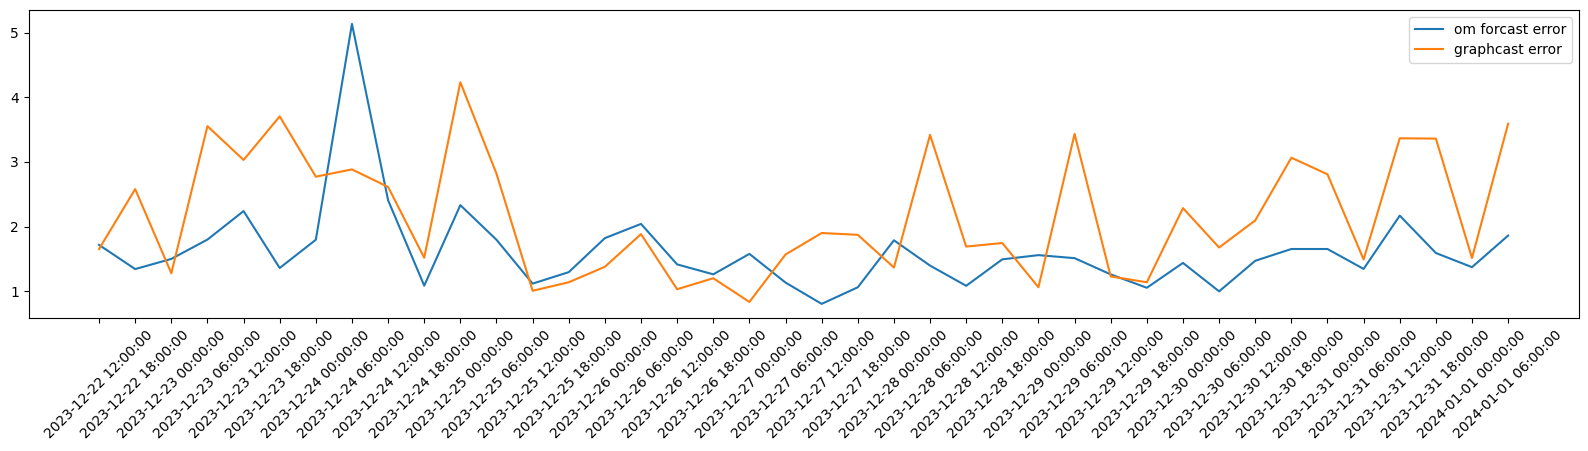

In [ ]:

plt.figure(figsize=(20, 4))
plt.plot(dates, mean_om_error)
plt.plot(dates, mean_gc_error)
plt.legend(['om forcast error', 'graphcast error'])
plt.xticks(rotation=45)
print()
